## Sentiment Analysis for Mental Health


In [1]:
# Install library
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 467.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 21.8 MB/s eta 0:00:00
   ━

In [2]:
# Import library
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from textblob import TextBlob
from wordcloud import WordCloud
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
string.punctuation
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Data Extraction

In [3]:
# Import and display dataset
df = pd.read_csv("/content/mental_health_sentiment_analysis.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
# Rename column
df.rename(columns={'Unnamed: 0': 'Tweet Id'}).head()

,Tweet Id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
# Check total rows and columns in dataset
df.shape

(53043, 3)

In [6]:
# Describe pattern from dataset
df.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [7]:
# Check data types from each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [8]:
# Check missing values
df.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [9]:
# Show data that have missing values
df.loc[df.isnull().any(axis=1)]

,Unnamed: 0,statement,status
293,293,NaN,Anxiety
572,572,NaN,Anxiety
595,595,NaN,Anxiety
1539,1539,NaN,Normal
2448,2448,NaN,Normal
...,...,...,...
52838,52838,NaN,Anxiety
52870,52870,NaN,Anxiety
52936,52936,NaN,Anxiety
53010,53010,NaN,Anxiety


In [10]:
# Fill misisng values
df.fillna('unknown', inplace=True)
df.isnull().sum()

,0
Unnamed: 0,0
statement,0
status,0


### Text Pre-processing

In [11]:
#selection data
text = df[['statement']]
text.head()

,statement
0,oh my gosh
1,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ..."
3,I've shifted my focus to something else but I'...
4,"I'm restless and restless, it's been a month n..."


In [12]:
# defining function to remove punctuation
def remove_punctuation(text):
        punctuationfree = "".join([i for i in text if i not in string.punctuation])
        return punctuationfree
# assuming 'text' is a pandas DataFrame
text['statement_punctuation'] = text['statement'].apply(remove_punctuation)
text.head()

<ipython-input-12-87a67fb4c300>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['statement_punctuation'] = text['statement'].apply(remove_punctuation)


,statement,statement_punctuation
0,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",All wrong back off dear forward doubt Stay in ...
3,I've shifted my focus to something else but I'...,Ive shifted my focus to something else but Im ...
4,"I'm restless and restless, it's been a month n...",Im restless and restless its been a month now ...


In [13]:
#setting lower case
text['statement_lower'] = text['statement_punctuation'].str.lower()
text.head()

,statement,statement_punctuation,statement_lower
0,oh my gosh,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",All wrong back off dear forward doubt Stay in ...,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Ive shifted my focus to something else but Im ...,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Im restless and restless its been a month now ...,im restless and restless its been a month now ...


In [14]:
#defining function for tokenization
def tokenization(text):
    tokens = re.split('W+', text)
    return tokens

#applying function to the column
text['statement_tokenized'] = text['statement_lower'].apply(lambda x: tokenization(x))
text.head()

,statement,statement_punctuation,statement_lower,statement_tokenized
0,oh my gosh,oh my gosh,oh my gosh,[oh my gosh]
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,[trouble sleeping confused mind restless heart...
2,"All wrong, back off dear, forward doubt. Stay ...",All wrong back off dear forward doubt Stay in ...,all wrong back off dear forward doubt stay in ...,[all wrong back off dear forward doubt stay in...
3,I've shifted my focus to something else but I'...,Ive shifted my focus to something else but Im ...,ive shifted my focus to something else but im ...,[ive shifted my focus to something else but im...
4,"I'm restless and restless, it's been a month n...",Im restless and restless its been a month now ...,im restless and restless its been a month now ...,[im restless and restless its been a month now...


In [15]:
#stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
text['statement_stopwords'] = text['statement_tokenized'].apply(lambda x:remove_stopwords(x))
text.head()

,statement,statement_punctuation,statement_lower,statement_tokenized,statement_stopwords
0,oh my gosh,oh my gosh,oh my gosh,[oh my gosh],[oh my gosh]
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,[trouble sleeping confused mind restless heart...,[trouble sleeping confused mind restless heart...
2,"All wrong, back off dear, forward doubt. Stay ...",All wrong back off dear forward doubt Stay in ...,all wrong back off dear forward doubt stay in ...,[all wrong back off dear forward doubt stay in...,[all wrong back off dear forward doubt stay in...
3,I've shifted my focus to something else but I'...,Ive shifted my focus to something else but Im ...,ive shifted my focus to something else but im ...,[ive shifted my focus to something else but im...,[ive shifted my focus to something else but im...
4,"I'm restless and restless, it's been a month n...",Im restless and restless its been a month now ...,im restless and restless its been a month now ...,[im restless and restless its been a month now...,[im restless and restless its been a month now...


In [16]:
#defining the object for stemming
porter_stemmer = PorterStemmer()

#defining a function for stemming
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

#applying the function
text['statement_stemmed'] = text['statement_stopwords'].apply(lambda x: stemming(x))
text.head()

,statement,statement_punctuation,statement_lower,statement_tokenized,statement_stopwords,statement_stemmed
0,oh my gosh,oh my gosh,oh my gosh,[oh my gosh],[oh my gosh],[oh my gosh]
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,[trouble sleeping confused mind restless heart...,[trouble sleeping confused mind restless heart...,[trouble sleeping confused mind restless heart...
2,"All wrong, back off dear, forward doubt. Stay ...",All wrong back off dear forward doubt Stay in ...,all wrong back off dear forward doubt stay in ...,[all wrong back off dear forward doubt stay in...,[all wrong back off dear forward doubt stay in...,[all wrong back off dear forward doubt stay in...
3,I've shifted my focus to something else but I'...,Ive shifted my focus to something else but Im ...,ive shifted my focus to something else but im ...,[ive shifted my focus to something else but im...,[ive shifted my focus to something else but im...,[ive shifted my focus to something else but im...
4,"I'm restless and restless, it's been a month n...",Im restless and restless its been a month now ...,im restless and restless its been a month now ...,[im restless and restless its been a month now...,[im restless and restless its been a month now...,[im restless and restless its been a month now...


In [17]:
#defining the object for lemmatizing
lemmatizer = WordNetLemmatizer()

#defining a function for lemmatizing
def lemmatize_words(text):
    lemma_text = [lemmatizer.lemmatize(word) for word in text]
    return lemma_text

#applying the function
text['statement_lemmatized'] = text['statement_stemmed'].apply(lambda text: lemmatize_words(text))
text.head()

,statement,statement_punctuation,statement_lower,statement_tokenized,statement_stopwords,statement_stemmed,statement_lemmatized
0,oh my gosh,oh my gosh,oh my gosh,[oh my gosh],[oh my gosh],[oh my gosh],[oh my gosh]
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,[trouble sleeping confused mind restless heart...,[trouble sleeping confused mind restless heart...,[trouble sleeping confused mind restless heart...,[trouble sleeping confused mind restless heart...
2,"All wrong, back off dear, forward doubt. Stay ...",All wrong back off dear forward doubt Stay in ...,all wrong back off dear forward doubt stay in ...,[all wrong back off dear forward doubt stay in...,[all wrong back off dear forward doubt stay in...,[all wrong back off dear forward doubt stay in...,[all wrong back off dear forward doubt stay in...
3,I've shifted my focus to something else but I'...,Ive shifted my focus to something else but Im ...,ive shifted my focus to something else but im ...,[ive shifted my focus to something else but im...,[ive shifted my focus to something else but im...,[ive shifted my focus to something else but im...,[ive shifted my focus to something else but im...
4,"I'm restless and restless, it's been a month n...",Im restless and restless its been a month now ...,im restless and restless its been a month now ...,[im restless and restless its been a month now...,[im restless and restless its been a month now...,[im restless and restless its been a month now...,[im restless and restless its been a month now...


### Exploratory Data Analysis (EDA)

In [18]:
#selection data
df_new = text[['statement_lower']]
df_new.head()

,statement_lower
0,oh my gosh
1,trouble sleeping confused mind restless heart ...
2,all wrong back off dear forward doubt stay in ...
3,ive shifted my focus to something else but im ...
4,im restless and restless its been a month now ...


In [19]:
#create function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#create function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#apply function to data
df_new['Subjectivity'] = df_new['statement_lower'].apply(getSubjectivity)
df_new['Polarity'] = df_new['statement_lower'].apply(getPolarity)
df_new.head()

<ipython-input-19-6e8c9e7f0a8e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Subjectivity'] = df_new['statement_lower'].apply(getSubjectivity)
<ipython-input-19-6e8c9e7f0a8e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Polarity'] = df_new['statement_lower'].apply(getPolarity)


,statement_lower,Subjectivity,Polarity
0,oh my gosh,0.0000,0.0000
1,trouble sleeping confused mind restless heart ...,0.4500,-0.3000
2,all wrong back off dear forward doubt stay in ...,0.4500,-0.2500
3,ive shifted my focus to something else but im ...,0.0000,0.0000
4,im restless and restless its been a month now ...,0.6875,-0.3125


In [20]:
#create function to get sentiment data
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

#apply function to data
df_new['Sentiment'] = df_new['Polarity'].apply(getSentiment)
df_new.head()

<ipython-input-20-b5ad6a5ac494>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Sentiment'] = df_new['Polarity'].apply(getSentiment)


,statement_lower,Subjectivity,Polarity,Sentiment
0,oh my gosh,0.0000,0.0000,Neutral
1,trouble sleeping confused mind restless heart ...,0.4500,-0.3000,Negative
2,all wrong back off dear forward doubt stay in ...,0.4500,-0.2500,Negative
3,ive shifted my focus to something else but im ...,0.0000,0.0000,Neutral
4,im restless and restless its been a month now ...,0.6875,-0.3125,Negative


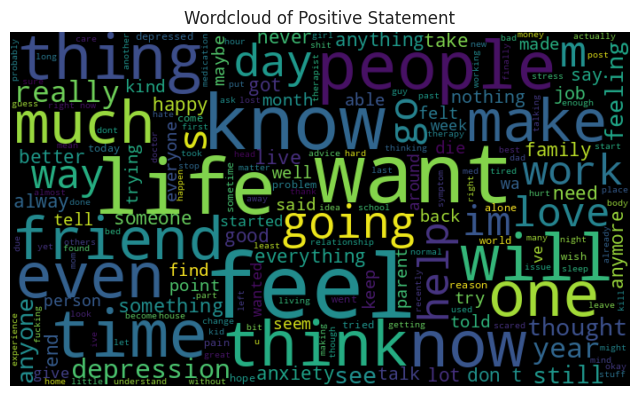

In [21]:
#visualize positive of tweet sentiment
positive = " ".join(df_new[df_new.Sentiment == 'Positive']['statement_lower'].values)
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100).generate(positive)

plt.figure(figsize = (8,5))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Positive Statement")
plt.axis('off')
plt.show()

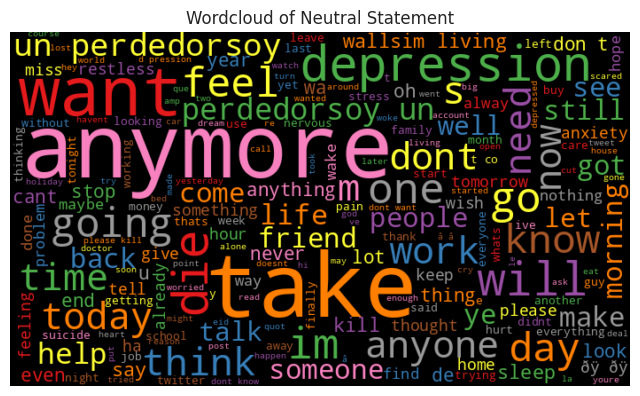

In [22]:
#visualize neutral of tweet sentiment
neutral = " ".join(df_new[df_new.Sentiment == 'Neutral']['statement_lower'].values)
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, colormap = 'Set1').generate(neutral)

plt.figure(figsize = (8,5))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Neutral Statement")
plt.axis('off')
plt.show()

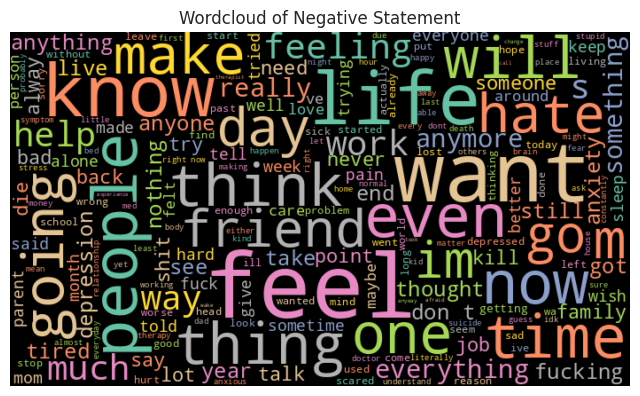

In [23]:
#visualize negative of tweet sentiment
negative = " ".join(df_new[df_new.Sentiment == 'Negative']['statement_lower'].values)
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, colormap = 'Set2').generate(negative)

plt.figure(figsize = (8,5))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Negative Statement")
plt.axis('off')
plt.show()

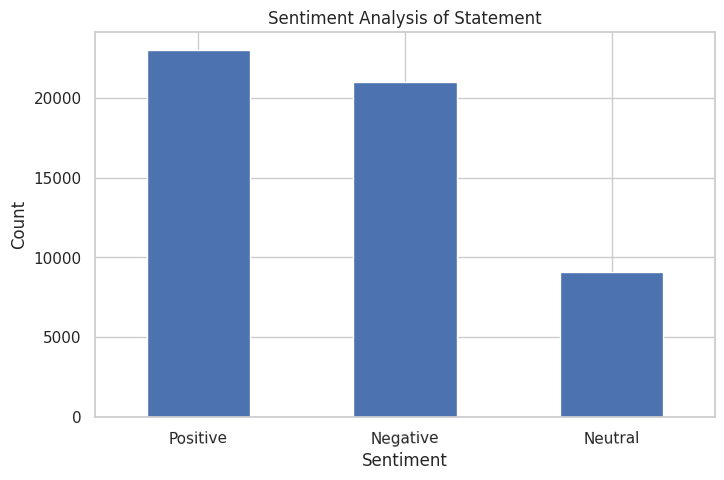

In [24]:
#visualize sentiment
plt.figure(figsize = (8,5))
plt.xlabel('Statement')
plt.ylabel('Count')
chart = df_new['Sentiment'].value_counts().plot(kind = 'bar')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 1)
plt.title("Sentiment Analysis of Statement")
plt.show()

<ipython-input-25-4e939335a8f7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticks(), rotation=0)  # Rotation set to 0 for readability


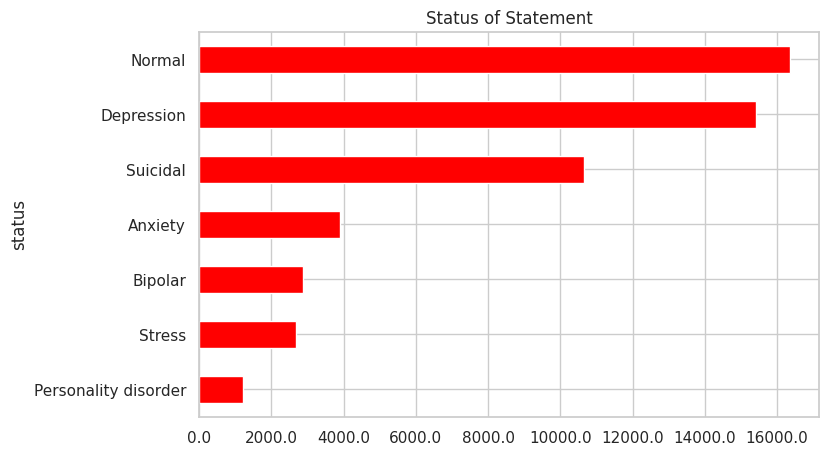

In [25]:
# Visualize status
plt.figure(figsize=(8, 5))
plt.xlabel('Count')
plt.ylabel('Statement')
# Get the value counts and sort them in descending order
status_counts = df['status'].value_counts(ascending=True)
# Plot the sorted value counts
chart = status_counts.plot(kind='barh', color='red')
# Adjusting xtick labels
chart.set_xticklabels(chart.get_xticks(), rotation=0)  # Rotation set to 0 for readability
plt.title("Status of Statement")
plt.show()

### Feature Engineering

In [26]:
# Selection data
df_new_cleaned = df_new[['statement_lower','Sentiment']]
df_new_cleaned.head()

,statement_lower,Sentiment
0,oh my gosh,Neutral
1,trouble sleeping confused mind restless heart ...,Negative
2,all wrong back off dear forward doubt stay in ...,Negative
3,ive shifted my focus to something else but im ...,Neutral
4,im restless and restless its been a month now ...,Negative


In [27]:
# Splitting Dataset
train,val = train_test_split(df_new_cleaned,test_size = 0.2)
print(train.shape)
print(val.shape)

(42434, 2)
(10609, 2)


In [28]:
# Add label column based on sentiments
train['label'] = train['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})
val['label'] = val['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

### ALBERT (A Lite BERT) Model

In [30]:
# Create a SimpleTransformers ClassificationModel
model = ClassificationModel(
    "albert",
    "albert-base-v2",
    num_labels=3,
    use_cuda=False  # Set this to False if you're not using a GPU
)

train_df = pd.DataFrame({
    'text': train['statement_lower'][:10000].replace(r'\n', ' ', regex=True),
    'label': train['label'][:10000]
})

eval_df = pd.DataFrame({
    'text': val['statement_lower'][-2000:].replace(r'\n', ' ', regex=True),
    'label': val['label'][-2000:]
})
model.train_model(train_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

(1250, 0.597920884245634)

In [31]:
# Evaluation model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

{'mcc': 0.7482973994523253, 'eval_loss': 0.4157078042626381}


In [32]:
# Model Output
print(model_outputs)

[[-0.2443624  -2.37464476  3.21048498]
 [-0.50252604 -2.33001113  3.21055174]
 [ 3.01198673 -2.9628005   0.75485027]
 ...
 [-1.50651813 -0.82178146  1.68292642]
 [-0.717134   -3.12085104  3.50363588]
 [ 1.26348948  0.41965693 -1.30469394]]


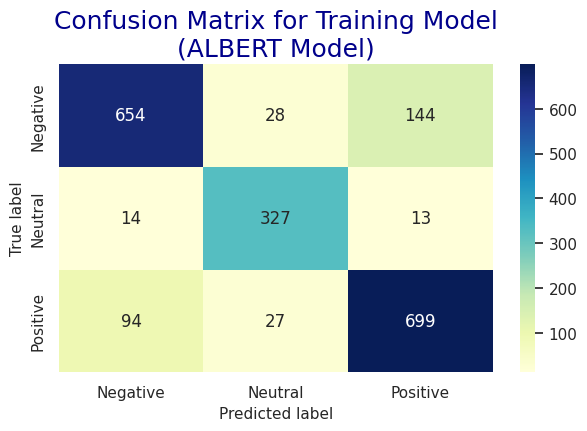

In [33]:
# Confusion Matrix
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = eval_df['label'].tolist()
predicted = lst

confusion_matrix_df = pd.DataFrame((confusion_matrix(true,predicted)), ('Negative','Neutral','Positive'), ('Negative','Neutral','Positive'))
plt.figure(figsize=(7, 4))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 12}, fmt='d', cmap='YlGnBu')

plt.title('Confusion Matrix for Training Model\n(ALBERT Model)',fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=11)
plt.xlabel('Predicted label', fontsize=11)
plt.show()

In [34]:
# Classification Report
cr = classification_report(true,predicted,target_names=['positive','neutral','negative'])
print(cr)

              precision    recall  f1-score   support

    positive       0.86      0.79      0.82       826
     neutral       0.86      0.92      0.89       354
    negative       0.82      0.85      0.83       820

    accuracy                           0.84      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.84      0.84      0.84      2000



In [35]:
# Accuracy Score
print('Accuracy Score: ', accuracy_score(true,predicted))

Accuracy Score:  0.84
